In [2]:
from pyght.src.AnniesLasso.thecannon.vectorizer.polynomial import PolynomialVectorizer
from pyght.src.AnniesLasso.thecannon.model import CannonModel
import pickle
from pyght.src.sfh import SFH
from astropy.io import fits
import numpy as np

In [3]:
filepath = '/data/mustard/vmehta/sfh_100_10_20251102_130203/sfh_100_10_20251102_130203'
labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

data = fits.getdata(f"{filepath}_weights.fits")
data = np.log10(data)

flux = np.load(f"{filepath}_snr_spectra.npy", allow_pickle=True)
ivar = np.load(f"{filepath}_snr_invvar.npy", allow_pickle=True)
wav = np.load(f"{filepath}_wavelength.npy", allow_pickle=True)

vectorizer = PolynomialVectorizer(labels, 2)

In [4]:
model = CannonModel(data, flux, ivar, vectorizer=vectorizer, dispersion=wav)

model.train()
model.write('model.pkl')

2025-11-06 09:49:35,544 [INFO] Training 10-label CannonModel with 100 stars and 1667 pixels/star
stty: 'standard input'2025-11-06 09:49:35,549 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[=========                                                                                           ]   9% (145/1667)                          

: Inappropriate ioctl for device


[========================================================================================================] 100% (2s)                                 
Saved model to model.pkl


In [5]:
model_loaded = pickle.load(open('model.pkl', 'rb'))
linear_terms = model_loaded['theta'][:, 1:11]

In [6]:
spec = SFH(sfh_weights=1/10*np.ones((1, 10)))

In [7]:
def moving_average(x, w):
        """Returns the moving average of the input array."""
        return np.convolve(x, np.ones(w), 'same') / w

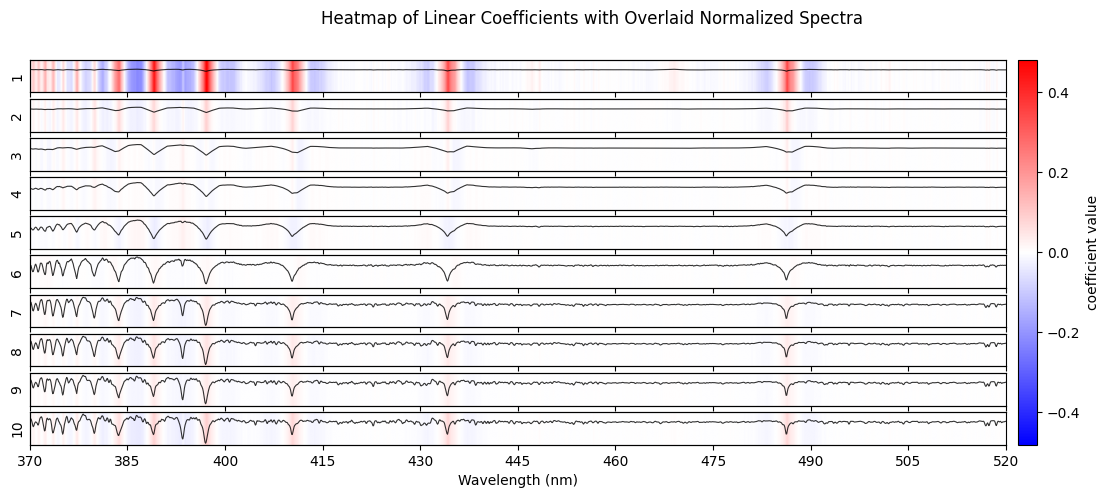

In [8]:
# Combined heatmap + overlaid normalized spectra (aligned and not flipped)
import numpy as np
import matplotlib.pyplot as plt

# Build heatmap from linear terms
arr = linear_terms.T  # shape: (n_labels, n_pixels)
n_labels, n_pix = arr.shape

# Consistent color scale across all subplots
v = np.nanmax(np.abs(arr)) if np.isfinite(arr).any() else 1.0

fig, axes = plt.subplots(n_labels, 1, figsize=(15, 0.5*n_labels), sharex=True)
if n_labels == 1:
    axes = [axes]

# Draw heatmaps
for i in range(n_labels):
    im = axes[i].imshow(arr[i:i+1, :], aspect='auto', cmap='bwr', vmin=-v, vmax=v)
    try:
        axes[i].set_ylabel(str(labels[i]))
    except Exception:
        axes[i].set_ylabel(f"Row {i+1}")
        axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[-1].set_xlabel('Wavelength (nm)')
axes[-1].set_xticks(np.linspace(0, n_pix - 1, 11))
axes[-1].set_xticklabels(['370','385','400','415','430','445','460','475','490','505','520'])

# Prepare normalized spectra for each bin
avgs = spec.get_averages()
vals = list(avgs.values())

def normalize(v):
    s_flat = v / moving_average(v, 100)
    return s_flat * moving_average(np.ones_like(s_flat), 100) - 1  # dealing with edges

norm_vals = [normalize(v) for v in vals]

wav_inc = wav if wav[0] <= wav[-1] else wav[::-1]
spec_wav_inc = spec.wav if spec.wav[0] <= spec.wav[-1] else spec.wav[::-1]

aligned_vals = []
for y in norm_vals:
    y_use = y if spec.wav[0] <= spec.wav[-1] else y[::-1]
    if len(y_use) != n_pix or not np.allclose(wav_inc, spec_wav_inc, rtol=0, atol=1e-6):
        # Interpolate spectrum onto the model dispersion grid
        y_interp = np.interp(wav_inc, spec_wav_inc, y_use)
    else:
        y_interp = y_use
    # If `wav` was decreasing originally, flip back to match the heatmap pixel order (0..n_pix-1 left->right)
    if wav[0] > wav[-1]:
        y_interp = y_interp[::-1]
    aligned_vals.append(y_interp)

# Compute a shared y-range across all spectra
all_vals = np.concatenate(aligned_vals)
ymin_global = np.nanmin(all_vals)
ymax_global = np.nanmax(all_vals)
if np.isfinite(ymin_global) and np.isfinite(ymax_global) and ymin_global != ymax_global:
    pad = 0.05 * (ymax_global - ymin_global)
    ylim_shared = (ymin_global - pad, ymax_global + pad)
else:
    ylim_shared = (-0.1, 0.1)

# Overlay with a secondary y-axis so scaling doesn't squash the image
for i in range(n_labels):
    ax2 = axes[i].twinx()
    yline = aligned_vals[i]
    ax2.plot(np.arange(n_pix), yline, color='k', linewidth=0.8, alpha=0.8, zorder=3)
    ax2.set_ylim(ylim_shared)  # Use shared y-range for all spectra
    ax2.set_yticks([])
    ax2.spines['right'].set_linewidth(0.5)
    ax2.spines['right'].set_alpha(0.5)

# Single colorbar for all subplots on the right
cbar = fig.colorbar(im, ax=axes, orientation='vertical', location='right', pad=0.01)
cbar.set_label('coefficient value')
fig.suptitle('Heatmap of Linear Coefficients with Overlaid Normalized Spectra')
plt.show()

In [9]:
s6 = list(avgs.values())[5]
s6_flat = s6 / moving_average(s6, 100)
s6_final = s6_flat * moving_average(np.ones_like(s6_flat), 100) # dealing with edges

In [10]:
w = s6_final.argmin()
s6

array([8.51847279e-16, 9.11405962e-16, 8.97451759e-16, ...,
       2.05415481e-15, 2.05664574e-15, 2.05226453e-15], shape=(1667,))

In [12]:
flux[:,w]

array([0.86632726, 0.89405283, 0.87702281, 0.91855654, 0.83148646,
       0.88443753, 0.94533526, 0.78176604, 0.7907242 , 0.80613332,
       0.80269675, 0.80392624, 0.85921433, 0.93991236, 0.92833677,
       0.91450044, 0.86713229, 0.87300104, 0.91251523, 0.82237022,
       0.86585264, 0.91436128, 0.83300636, 0.81254796, 0.91733403,
       0.89569544, 0.86711933, 0.87078939, 0.66303011, 0.86257099,
       0.86782754, 0.88772568, 0.87340041, 0.82417305, 0.8230419 ,
       0.90496637, 0.9095915 , 0.82407242, 0.76985742, 0.85116436,
       0.81741944, 0.87058219, 0.86527246, 0.86399245, 0.91109468,
       0.89503855, 0.84229265, 0.86310283, 0.86501149, 0.60679791,
       0.83435984, 0.84053118, 0.89688463, 0.86342657, 0.84816513,
       0.73888133, 0.88305597, 0.7891448 , 0.85107339, 0.82966189,
       0.84628946, 0.89248526, 0.82642263, 0.90316722, 0.79712306,
       0.87721994, 0.8895049 , 0.86665841, 0.8333639 , 0.88530037,
       0.91969108, 0.85078095, 0.80504781, 0.70113408, 0.88388

In [17]:
x = data[:,5]
y = flux[:,w]

const = model_loaded['theta'][w, 0]
linear = model_loaded['theta'][w, 6]

def quad_theta_index(a, b, n_labels=10):
    a, b = sorted((int(a), int(b)))
    offset = (a - 1) * (n_labels + 1) - (a - 1) * a // 2 + (b - a)
    return 1 + n_labels + offset

idx_7_sq = quad_theta_index(6, 6, n_labels=10)
quad = model_loaded['theta'][w, idx_7_sq]


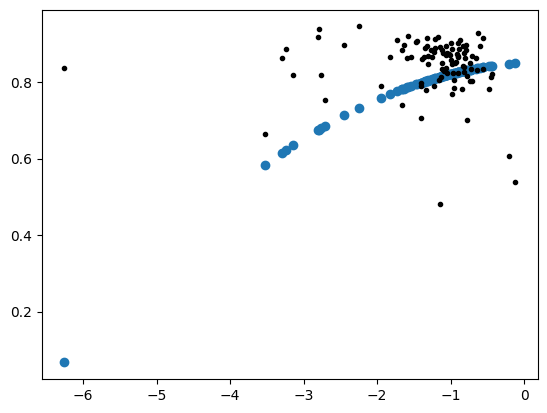

In [18]:
def f(x):
    return const + linear*x + quad*x**2
plt.plot(x, y, 'k.')
plt.scatter(x,f(x))

In [12]:
spec.wav

array([3699.9526, 3700.853 , 3701.7531, ..., 5197.9471, 5198.8472,
       5199.7474], shape=(1667,))